In [2]:
!pip install transformers
!pip install emoji
!pip install sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 20.8 MB/s eta 0:00:00


In [3]:
import torch
import json
import random
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import time
import datetime
import random
import re
import numpy as np
import emoji
from transformers import *
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from sklearn.metrics import accuracy_score,f1_score
from sklearn.utils.class_weight import compute_class_weight
#from transformers import LongformerTokenizer, LongformerForSequenceClassification
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, DataLoader
from sklearn.metrics import *


# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name())

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


/usr/local/lib/python3.10/dist-packages/transformers/deepspeed.py:24: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
GroupViT models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version.Please try to reinstall it following the instructions he

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [4]:
from transformers import *

In [5]:
params={
    'max_length':256,
    'path_files': 'Hate-speech-CNERG/dehatebert-mono-arabic',
    'what_bert':'weighted',
    'batch_size':24,
    'is_train':True,
    'learning_rate':2e-5,
    'epsilon':1e-8,
    'random_seed':30,
    'epochs':1,
    'to_save':True,
    'weights':[0.1785,0.8215],
    'frac':0.8
}

In [6]:
def Diff(a,b):
    return list(set(a) -set(b))

def re_sub(pattern, repl,text):
    return re.sub(pattern, repl, text)


def preprocess_sent(sent):
    sent = re.sub(r"http\S+", "", sent)
    sent = re.sub(r"@\S+", "@user", sent)

    #print(sent)
    sent = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "",sent)
    sent = emoji.demojize(sent)
    sent = re_sub(r"[:\*]", " ",sent)
    return sent

def evalMetric(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    mf1Score = f1_score(y_true, y_pred, average='macro')
    f1Score  = f1_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    area_under_c = auc(fpr, tpr)
    recallScore = recall_score(y_true, y_pred)
    precisionScore = precision_score(y_true, y_pred)
    return {"accuracy": accuracy, 'mF1Score': mf1Score, 'f1Score': f1Score, 'auc': area_under_c,
            'precision': precisionScore, 'recall': recallScore}


#Creating an attention mask - For actual tokens its set to 1, for padding tokens its set to 0
def create_attention_masks(input_ids):
    attention_masks = []
    for seq in tqdm(input_ids):
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return np.array(attention_masks)

def getFeaturesandLabel(X,y):
    sentences = list(X)
    sentences = ["[CLS] "+ i + " [SEP]"for i in sentences]
    tokenizer_texts = list(map(lambda t: tokenizer.tokenize(t)[:512], tqdm(sentences)))
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(tokenizer_texts)]
    input_ids = pad_sequences(sequences = input_ids, maxlen = param['maxLen'], dtype = 'long', padding='post', truncating='post')
    attention_masks_data = create_attention_masks(input_ids)
    X_data = torch.tensor(input_ids)
    attention_masks_data = torch.tensor(attention_masks_data)
    y_data = torch.tensor(y)
    return X_data, attention_masks_data, y_data


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import pandas as pd
trainData = pd.read_csv("/content/drive/MyDrive/Urdu/UrduThreat/train.csv")

In [9]:
X, y  = list(trainData['tweet']), list(trainData['target'])

In [10]:
sum(y)/len(y)

0.1785

In [11]:
from sklearn.model_selection import train_test_split

# given:
# features: xs
# ground truth: ys

#X_tn, X_v, y_tn, y_v = train_test_split(X, y, test_size=0.15, random_state=2021, stratify=y)

In [12]:
X_tn , y_tn = X, y

In [13]:

test = pd.read_csv("/content/drive/MyDrive/Urdu/UrduThreat/test.csv")


# In[9]:


X_ts = list(test['tweet'])
y_ts = [0] *len(X_ts)

In [14]:
tokenizer = BertTokenizer.from_pretrained('Hate-speech-CNERG/dehatebert-mono-arabic', do_lower_case = True)

tokenizer_config.json:   0%|          | 0.00/152 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--Hate-speech-CNERG--dehatebert-mono-arabic/snapshots/e592a5ee3b913ec33286ee90fb27c7f7f1a8b996/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--Hate-speech-CNERG--dehatebert-mono-arabic/snapshots/e592a5ee3b913ec33286ee90fb27c7f7f1a8b996/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--Hate-speech-CNERG--dehatebert-mono-arabic/snapshots/e592a5ee3b913ec33286ee90fb27c7f7f1a8b996/tokenizer_config.json
loading file tokenizer.json from cache at None


config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--Hate-speech-CNERG--dehatebert-mono-arabic/snapshots/e592a5ee3b913ec33286ee90fb27c7f7f1a8b996/config.json
Model config BertConfig {
  "_name_or_path": "Hate-speech-CNERG/dehatebert-mono-arabic",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "eos_token_ids": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.3,
  "hidden_size": 768,
  "id2label": {
    "0": "NON_HATE",
    "1": "HATE"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "HATE": 1,
    "NON_HATE": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": null,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "poole

In [15]:
param ={
    'maxLen' :256,
}


In [16]:
X_train, attention_masks_train, y_train = getFeaturesandLabel(X_tn,y_tn)
#X_val, attention_masks_val, y_val = getFeaturesandLabel(X_v,y_v)
X_test, attention_masks_test, y_test = getFeaturesandLabel(X_ts,y_ts)

100%|██████████| 3950/3950 [00:00<00:00, 6424.86it/s]


In [17]:
BATCH_SIZE = 24
#Dataset wrapping tensors.
train_data = TensorDataset(X_train, attention_masks_train, y_train)
#val_data = TensorDataset(X_val, attention_masks_val, y_val)
test_data = TensorDataset(X_test, attention_masks_test, y_test)

#Samples elements randomly. If without replacement(default), then sample from a shuffled dataset.
train_sampler = RandomSampler(train_data)
#val_sampler = SequentialSampler(val_data)
test_sampler = SequentialSampler(test_data)

#represents a Python iterable over a dataset
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = BATCH_SIZE)
#validation_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = BATCH_SIZE)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = BATCH_SIZE)


In [18]:
# Class for weighted bert for sentence classification
class SC_weighted_BERT(BertPreTrainedModel):
    def __init__(self, config,weights):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.weights=weights
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, self.config.num_labels)
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
    ):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(self.weights).cuda())
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

In [19]:
def select_model(type_of_model,path,weights=None,label_list=None):
    if(type_of_model=='weighted'):
        model = SC_weighted_BERT.from_pretrained(
        path, # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 2, # The number of output labels--2 for binary classification             # You can increase this for multi-class tasks.
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
        weights=weights
    )
    else:
        print("Error in model name!!!!")
    return model

In [20]:
import torch
import torch.nn as nn

In [21]:
model = select_model(params['what_bert'], params['path_files'], params['weights'])

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--Hate-speech-CNERG--dehatebert-mono-arabic/snapshots/e592a5ee3b913ec33286ee90fb27c7f7f1a8b996/config.json
Model config BertConfig {
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "eos_token_ids": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.3,
  "hidden_size": 768,
  "id2label": {
    "0": "NON_HATE",
    "1": "HATE"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "HATE": 1,
    "NON_HATE": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": null,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform"

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--Hate-speech-CNERG--dehatebert-mono-arabic/snapshots/e592a5ee3b913ec33286ee90fb27c7f7f1a8b996/pytorch_model.bin
All model checkpoint weights were used when initializing SC_weighted_BERT.

All the weights of SC_weighted_BERT were initialized from the model checkpoint at Hate-speech-CNERG/dehatebert-mono-arabic.
If your task is similar to the task the model of the checkpoint was trained on, you can already use SC_weighted_BERT for predictions without further training.


In [22]:
import numpy as np
def getProb(temp):
    t = np.exp(temp)
    return t[1]/(sum(t))


In [23]:
def getPerformanceOfLoader(test_dataloader):
    model.eval()
    # Tracking variables
    predictions , true_labels = [], []
    # Predict
    for batch in test_dataloader:
    #print(batch)
    # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Store predictions and true labels
        predictions.extend(logits)
        true_labels.extend(label_ids)

    print('DONE.')
    predict =[]
    proba = []
    for i in predictions:
        if i[0]>= i[1]:
            predict.append(0)
        else:
            predict.append(1)
        proba.append(getProb(i))

    df = pd.DataFrame()
    df['id']=test['id']
    df['target'] = predict
    df['score'] = proba
    return df

In [24]:
# Tell pytorch to run this model on the GPU.
model.cuda()

bestValAcc  = 0
besttest_df  = None

# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

epochs = 10
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
loss_values = []

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()

        outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        # The call to `model` always returns a tuple, so we need to pull the
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    # print("Running Validation...")

    # t0 = time.time()

    # # Put the model in evaluation mode--the dropout layers behave differently
    # # during evaluation.
    # model.eval()

    # # Tracking variables
    # eval_loss, eval_accuracy = 0, 0
    # nb_eval_steps, nb_eval_examples = 0, 0

    # # Evaluate data for one epoch
    # for batch in validation_dataloader:

    #     # Add batch to GPU
    #     batch = tuple(t.to(device) for t in batch)

    #     # Unpack the inputs from our dataloader
    #     b_input_ids, b_input_mask, b_labels = batch

    #     # Telling the model not to compute or store gradients, saving memory and
    #     # speeding up validation
    #     with torch.no_grad():

    #         # Forward pass, calculate logit predictions.
    #         # This will return the logits rather than the loss because we have
    #         # not provided labels.
    #         # token_type_ids is the same as the "segment ids", which
    #         # differentiates sentence 1 and 2 in 2-sentence tasks.
    #         # The documentation for this `model` function is here:
    #         # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    #         outputs = model(b_input_ids,
    #                         token_type_ids=None,
    #                         attention_mask=b_input_mask)

    #     # Get the "logits" output by the model. The "logits" are the output
    #     # values prior to applying an activation function like the softmax.
    #     logits = outputs[0]

    #     # Move logits and labels to CPU
    #     logits = logits.detach().cpu().numpy()
    #     label_ids = b_labels.to('cpu').numpy()

    #     # Calculate the accuracy for this batch of test sentences.
    #     tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    #     # Accumulate the total accuracy.
    #     eval_accuracy += tmp_eval_accuracy

    #     # Track the number of batches
    #     nb_eval_steps += 1

    # # Report the final accuracy for this validation run.
    # if ((eval_accuracy/nb_eval_steps) > bestValAcc):
    #      bestValAcc  = eval_accuracy/nb_eval_steps
    #      besttest_df = getPerformanceOfLoader(test_dataloader)
    # print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    # print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 10 ========
Training...
  Batch    40  of    250.    Elapsed: 0:00:39.
  Batch    80  of    250.    Elapsed: 0:01:20.
  Batch   120  of    250.    Elapsed: 0:02:00.
  Batch   160  of    250.    Elapsed: 0:02:40.
  Batch   200  of    250.    Elapsed: 0:03:20.
  Batch   240  of    250.    Elapsed: 0:04:01.

  Average training loss: 0.67
  Training epcoh took: 0:04:11


======== Epoch 2 / 10 ========
Training...
  Batch    40  of    250.    Elapsed: 0:00:40.
  Batch    80  of    250.    Elapsed: 0:01:21.
  Batch   120  of    250.    Elapsed: 0:02:01.
  Batch   160  of    250.    Elapsed: 0:02:41.
  Batch   200  of    250.    Elapsed: 0:03:21.
  Batch   240  of    250.    Elapsed: 0:04:02.

  Average training loss: 0.61
  Training epcoh took: 0:04:12


======== Epoch 3 / 10 ========
Training...
  Batch    40  of    250.    Elapsed: 0:00:40.
  Batch    80  of    250.    Elapsed: 0:01:20.
  Batch   120  of    250.    Elapsed: 0:02:01.
  Batch   160  of    250.    Elapsed:

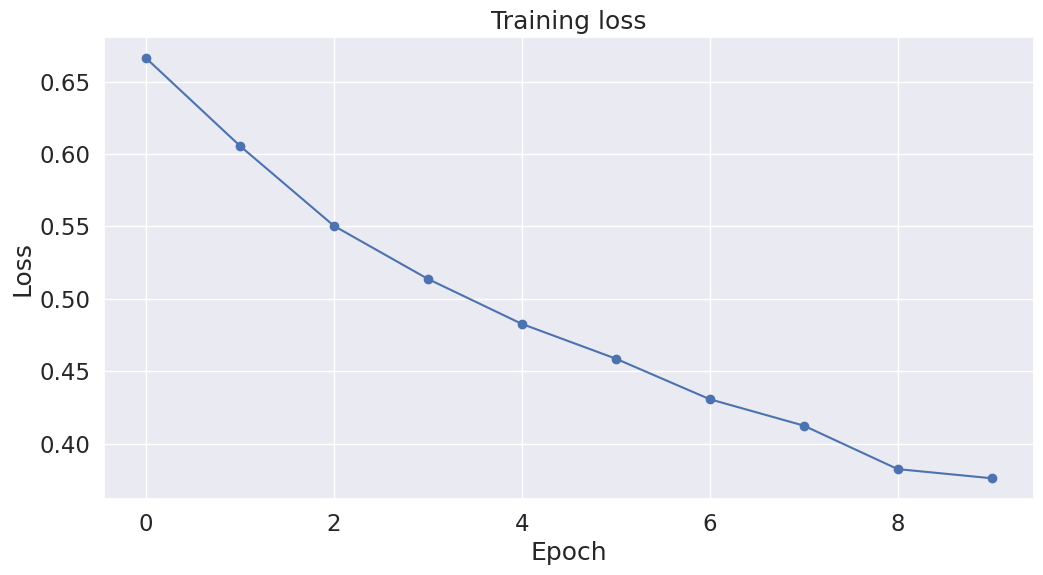

In [25]:
import matplotlib.pyplot as plt
#%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [26]:

# Prediction on test set

#print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in test_dataloader:
    #print(batch)
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    # Store predictions and true labels
    predictions.extend(logits)
    true_labels.extend(label_ids)

print('DONE.')

DONE.


In [27]:
import numpy as np
def getProb(temp):
    t = np.exp(temp)
    return t[1]/(sum(t))


In [28]:
predict =[]
proba = []
for i in predictions:
    if i[0]>= i[1]:
        predict.append(0)
    else:
        predict.append(1)
    proba.append(getProb(i))

df = pd.DataFrame()
df['id']=test['id']
df['target'] = predict
df['score'] = proba

In [29]:
df = pd.DataFrame()
df['id']=test['id']
df['target'] = predict
df['score'] = proba

In [31]:
df.to_csv("/content/drive/MyDrive/Urdu/UrduThreat/mBERT_final_ThreatAll.csv")

In [32]:
df.to_csv("mBERT_final_ThreatAll.csv")

In [34]:
# besttest_df.to_csv("/content/drive/MyDrive/Urdu/UrduThreat/mBERT_arabic_best_threat24.csv")

AttributeError: 'NoneType' object has no attribute 'to_csv'

In [35]:
# besttest_df.head()

AttributeError: 'NoneType' object has no attribute 'head'

In [36]:
df.head()

,id,target,score
0,8980,0,0.027443
1,3784,0,0.006723
2,8312,1,0.770730
3,9932,1,0.921345
4,150,1,0.713863


In [37]:
sum(df['target'])

770